In [38]:
import warnings
import numpy as np
import pandas as pd

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from pycaret.clustering import *
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [39]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [40]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [41]:
device

'cuda:0'

In [42]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [43]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(device)

In [44]:
def emb(sentence):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return np.array(sentence_embeddings.to('cpu'))

In [45]:
dataset = pd.read_csv("Bend Export.csv")['Bio']

In [46]:
dataset.dropna(inplace=True)

In [47]:
dataset

0       "All things Cannabis!" Website: https://Cannaf...
1       "Cool."\r\ralt: @BbySadBoi shared w/ @Dasein4LifE
2                        "Currently Under Construction" 🖖
3       "Ever since I was a lowercase g, but now I'm a...
4       "I'm not popular enough to be different" - Hom...
                              ...                        
5110    🧁A shy Demi-Girl living in this crazy world🧁 🌺...
5111                                                🪩🪩🪩🪩🪩
5112                                               #NAME?
5113                                               #NAME?
5114                                               #NAME?
Name: Bio, Length: 5115, dtype: object

In [48]:
embeddings = []

In [49]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    list_string = [stemmer.lemmatize(word) for word in nopunc]
    
    return ' '.join([str(i) for i in list_string])

In [50]:
for i in range(len(dataset)):
    dataset[i] = text_process(dataset[i])

In [51]:
dataset

0              all thing cannabis website httpscannafocom
1                  cool alt bbysadboi shared w daseinlife
2                          currently under construction 🖖
3                       ever since i lowercase g im big g
4               im popular enough different homer simpson
                              ...                        
5110    🧁a shy demigirl living crazy world🧁 🌺disabled ...
5111                                                🪩🪩🪩🪩🪩
5112                                                 name
5113                                                 name
5114                                                 name
Name: Bio, Length: 5115, dtype: object

In [52]:
for i in range(len(dataset)):
    embeddings.append(emb(dataset[i])[0])

In [53]:
df = pd.DataFrame(embeddings)

In [66]:
sum_of_squared_dist = []
K = range(1,150)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    sum_of_squared_dist.append(km)

In [73]:
for i in range(len(sum_of_squared_dist)):
    sum_of_squared_dist[i] = sum_of_squared_dist[i].inertia_

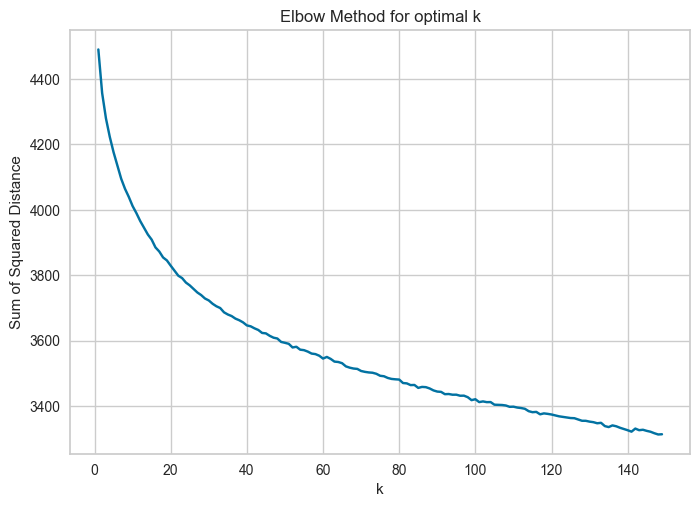

In [74]:
plt.plot(K,sum_of_squared_dist,'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distance')
plt.title('Elbow Method for optimal k')
plt.show()

In [ ]:
km = KMeans(n_clusters=50)
km = km.fit(df)